In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.svm import SVC 
from imblearn.over_sampling import SMOTE

In [2]:
#Define File Path
bert_path = "./vec_data/twc_news_vec.npz"
le_stance_labels = "./vec_data/le_stance_labels.npz"

In [4]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [5]:
bert_vec = load_npz_file(bert_path)
le_label = load_npz_file(le_stance_labels)

In [6]:
#指派實際要使用的Data與Label
data = bert_vec
label = le_label

In [7]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 768)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3]), array([ 11, 201,  74, 159], dtype=int64))


In [8]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
# oversample_ratio = {0: 100, 1: 201, 2: 120, 3: 159}
oversample_ratio = {0: 150, 1: 201, 2: 175, 3: 183}
# Initialize the oversampler
oversampler = SMOTE(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 768)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)

In [9]:
print(X_resampled.shape)
print(y_resampled.shape)

(709, 768)
(709,)


In [10]:
X_data, test_data, X_labels, test_labels = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.1)

In [11]:
print('Train data shape:', X_data.shape)
print('Train labels shape:', X_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

Train data shape: (638, 768)
Train labels shape: (638,)
Test data shape: (71, 768)
Test labels shape: (71,)


In [12]:
# Define the number of folds for k-fold cross-validation
num_folds = 5
# Initialize the k-fold cross-validator
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

# SVC parameters
kernels = list(['linear', 'rbf', 'poly', 'sigmoid'])
c_range = np.logspace(-2, 2, 5)
gammas = list([0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5, 1.0])

# Metrics reocrds
model_ac_list = []
model_pc_list = []
model_rc_list = []
model_f1_list = []

In [13]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, X_labels)):
    print(f'Fold {fold + 1}')
    X_train_fold = X_data[train_idx]
    y_train_fold = X_labels[train_idx]
    X_val_fold = X_data[val_idx]
    y_val_fold = X_labels[val_idx]

    grid_clf = SVC()
    param_grid = dict(kernel=kernels, C=c_range, gamma=gammas)
    grid = GridSearchCV(grid_clf, param_grid, cv=10, n_jobs=-1)
    grid.fit(X_train_fold, y_train_fold)
    best = grid.best_params_
    print(best)

    clf = SVC(C=best['C'], gamma=best['gamma'], kernel=best['kernel']) 
    clf.fit(X_train_fold, y_train_fold)
    y_pred = clf.predict(test_data)

    ac = accuracy_score(test_labels, y_pred)
    pc = precision_score(y_pred, test_labels, average='macro')
    rc = recall_score(y_pred, test_labels, average='macro')
    f1 = f1_score(y_pred, test_labels, average='macro')
    model_ac_list.append(ac)
    model_pc_list.append(pc)
    model_rc_list.append(rc)
    model_f1_list.append(f1)

Fold 1
{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
Fold 2
{'C': 0.01, 'gamma': 0.06, 'kernel': 'poly'}
Fold 3
{'C': 100.0, 'gamma': 0.05, 'kernel': 'rbf'}
Fold 4
{'C': 100.0, 'gamma': 0.05, 'kernel': 'rbf'}
Fold 5
{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}


In [14]:
Avg_ac = sum(model_ac_list)/len(model_ac_list)
Avg_pc = sum(model_pc_list)/len(model_pc_list)
Avg_rc = sum(model_rc_list)/len(model_rc_list)
Avg_f1 = sum(model_f1_list)/len(model_f1_list)

In [15]:
print('Avg Model Accuracy: {:.2%}'.format(Avg_ac))
print('Avg Model Precision: {:.2%}'.format(Avg_pc))
print('Avg Model Recall: {:.2%}'.format(Avg_rc))
print('Avg Model F1-score: {:.2%}'.format(Avg_f1))

Avg Model Accuracy: 75.77%
Avg Model Precision: 77.08%
Avg Model Recall: 77.89%
Avg Model F1-score: 77.35%


<AxesSubplot: >

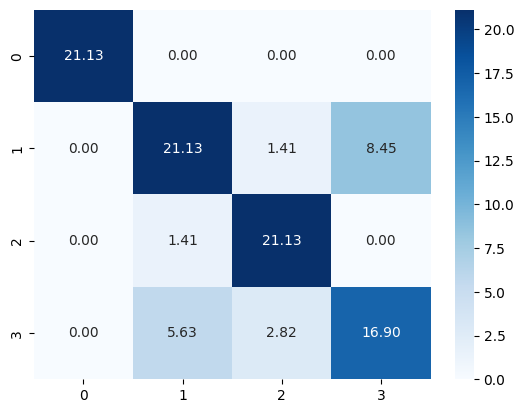

In [16]:
cf_matrix = confusion_matrix(y_pred, test_labels)
sns.heatmap((cf_matrix / np.sum(cf_matrix)*100), annot = True, fmt=".2f", cmap="Blues")